In [1]:
import lib
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# check if CUDA is available
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

True
Using device: cuda:0


In [3]:
data = lib.Dataset("YAHOO", random_state=1337, quantile_transform=True, quantile_noise=1e-3)
mu, std = data.y_train.mean(), data.y_train.std()
normalize = lambda x: ((x - mu) / std).astype(np.float32)
data.y_train, data.y_valid, data.y_test = map(normalize, [data.y_train, data.y_valid, data.y_test])

# transform the data into PyTorch tensors
X_train = torch.tensor(data.X_train.reshape(-1, 1, 699), dtype=torch.float32).to(device)
y_train = torch.tensor(data.y_train, dtype=torch.float32).to(device)
X_valid = torch.tensor(data.X_valid.reshape(-1, 1, 699), dtype=torch.float32).to(device)
y_valid = torch.tensor(data.y_valid, dtype=torch.float32).to(device)
X_test = torch.tensor(data.X_test.reshape(-1, 1, 699), dtype=torch.float32).to(device)
y_test = torch.tensor(data.y_test, dtype=torch.float32).to(device)

# create Tensor datasets
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

# create DataLoaders, which helps in efficient data loading, use batch_size=64
batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Initialize lists to save the losses
train_losses = []
val_losses = []

In [4]:
# create a CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 3)
        self.pool = nn.MaxPool1d(2)  
        self.conv2 = nn.Conv1d(64, 32, 3)
        # compute the length after the convolutional and pooling layers
        conv_size = (699 - 2) // 2 - 2  
        self.fc1 = nn.Linear(32 * conv_size, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # add a max pooling layer after the convolutional layer
        x = torch.relu(self.conv2(x))
        x = x.view(-1, 32 * ((699 - 2) // 2 - 2))  # correct dimension after update
        x = self.fc1(x)
        return x

In [5]:
# prepare for the training
# create an instance of the model and move it to the device
model = Net().to(device)
# define the loss function and the optimizer
criterion = nn.MSELoss()
# use the Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.01
optimizer = optim.SGD(model.parameters(), lr=0.01)
# use the ReduceLROnPlateau scheduler to reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

In [6]:
# train the model
num_epochs = 100  
patience = 15  # early stopping patience
best_val_loss = np.inf  # initialize the best validation loss
patience_counter = 0  # initialize the patience counter
model_path = ''  # initialize the path of the best model saved 

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        # clear the gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(batch_X)
        # compute the loss
        loss = criterion(outputs.squeeze(), batch_y)
        # backward pass
        loss.backward()
        # update the weights
        optimizer.step()
        total_loss += loss.item()

    # compute the average training loss
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # validate the model
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
            val_outputs = model(batch_X)
            val_loss = criterion(val_outputs.squeeze(), batch_y)
            total_val_loss += val_loss.item()

    # compute the average validation loss
    avg_val_loss = total_val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)
    # check if the validation loss has improved and if it needs early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the model if validation loss improves
        model_path = f'CNN_model_epoch_{epoch + 1}.pt'
        torch.save(model, model_path)
        print(f'Validation loss improved at epoch {epoch + 1}. Model saved at {model_path}')
        print(f'Average Training Loss at improvement: {avg_train_loss:.4f}')
        print(f'Average Validation Loss at improvement: {avg_val_loss:.4f}')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"After Epoch {epoch+1}: Early stopping due to validation loss not improving")
        print(f'Average Training Loss at stopping: {avg_train_loss:.4f}')
        print(f'Average Validation Loss at stopping: {avg_val_loss:.4f}')
        print(f'Model saved at epoch {epoch + 1 - patience} with lowest validation loss')
        break
    # if there is no early stopping, save the model after the last epoch
    if epoch == num_epochs - 1:
        model_path = f'CNN_model_epoch_{epoch + 1}.pt'
        torch.save(model, model_path)

Validation loss improved at epoch 1. Model saved at CNN_model_epoch_1.pt
Average Training Loss at improvement: 0.6573
Average Validation Loss at improvement: 0.6634
Validation loss improved at epoch 2. Model saved at CNN_model_epoch_2.pt
Average Training Loss at improvement: 0.6381
Average Validation Loss at improvement: 0.6611
Validation loss improved at epoch 3. Model saved at CNN_model_epoch_3.pt
Average Training Loss at improvement: 0.6324
Average Validation Loss at improvement: 0.6529
Validation loss improved at epoch 7. Model saved at CNN_model_epoch_7.pt
Average Training Loss at improvement: 0.6225
Average Validation Loss at improvement: 0.6501
Validation loss improved at epoch 13. Model saved at CNN_model_epoch_13.pt
Average Training Loss at improvement: 0.6151
Average Validation Loss at improvement: 0.6497
Validation loss improved at epoch 16. Model saved at CNN_model_epoch_16.pt
Average Training Loss at improvement: 0.6129
Average Validation Loss at improvement: 0.6480
Valida

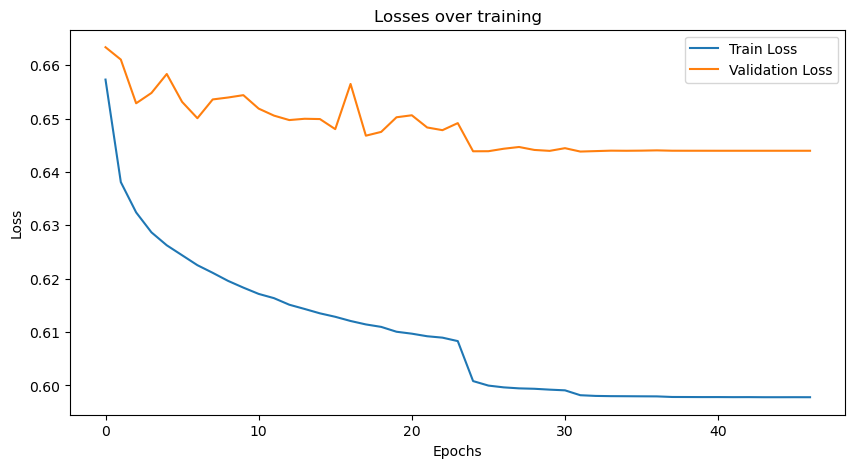

In [7]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses over training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# test the model
# load the model with the best validation loss
model = torch.load(model_path).to(device)
model.eval()

y_test_pred_list = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)  # move the data to the GPU
        y_test_pred = model(X_batch).detach().cpu().numpy()
        y_test_pred_list.append(y_test_pred)
y_test_pred = np.concatenate(y_test_pred_list)
y_test_pred = np.squeeze(y_test_pred)

print("Test MSE:", round(np.mean(np.square(y_test_pred * std - data.y_test * std)), 4))

Test MSE: 0.6022
